In [1]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

In [3]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(self.shape)

In [4]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        image_values = torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Reds')
    


In [5]:
mnist_dataset = MnistDataset('/content/mount/MyDrive/GANs mit Pytorch/mnist_data/mnist_train.csv')

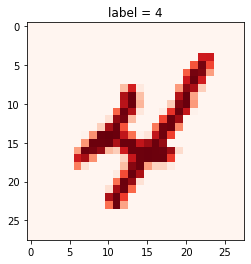

In [6]:
mnist_dataset.plot_image(9)

In [7]:
class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
        
            # 10 filters to 10 filters
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters())

        self.counter = 0
        self.progress = []

    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

        

In [8]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla K80


device(type='cuda')

In [9]:
%%time 

C = Classifier()
C.to(device)


epochs = 10

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)

training epoch 1 of 10
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 10
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 10
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 10
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
training epoch 5 of 10
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
training epoch 6 of 10
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
training epoch 7 of 10
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
training epoch 8 of 10
counter =  430000
counter =  440000
counter =  450000
counter =  4600

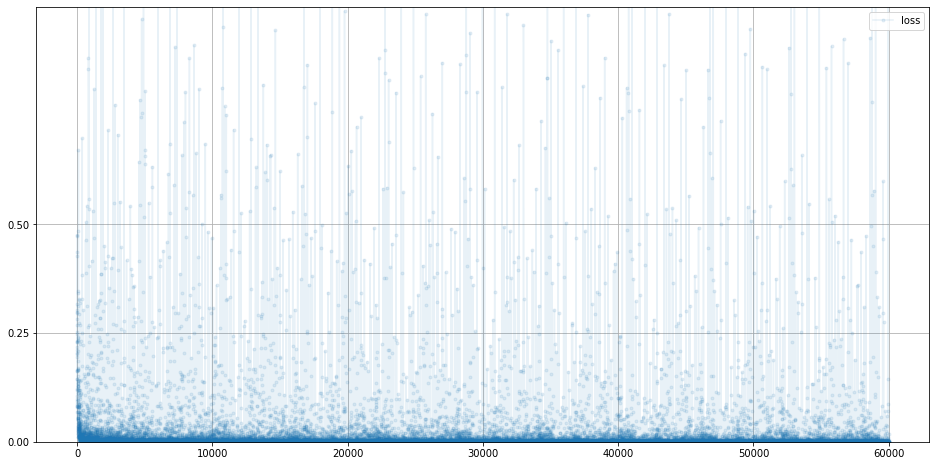

In [10]:
C.plot_progress()

In [11]:
mnist_test_dataset = MnistDataset('/content/mount/MyDrive/GANs mit Pytorch/mnist_data/mnist_test.csv')

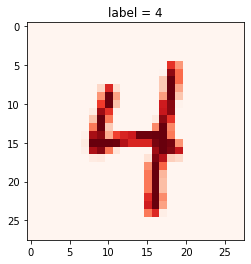

In [12]:
record = 19

mnist_test_dataset.plot_image(record)

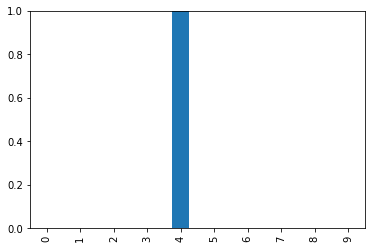

In [15]:
image_data = mnist_test_dataset[record][1]

output = C.forward(image_data.view(1,1,28,28))
output = output.cpu()

pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [17]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28))
    answer = answer.cpu()
    answer = answer.detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9822 10000 0.9822


# Conditional GAN mnist

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [19]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        image_values = torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Reds')

In [20]:
mnist_dataset = MnistDataset('/content/mount/MyDrive/GANs mit Pytorch/mnist_data/mnist_train.csv')

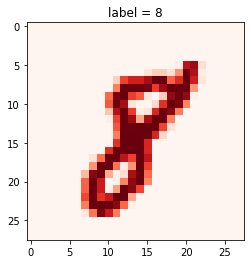

In [21]:
mnist_dataset.plot_image(17)

In [22]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

def generate_random_one_hot(size):
  label_tensor = torch.zeros((size))
  random_idx = random.randint(0,size-1)
  label_tensor[random_idx] = 1.0
  return label_tensor


In [23]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []

    
    
    def forward(self, image_tensor, label_tensor):
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)
        
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
      

In [24]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla K80


device(type='cuda')

In [25]:
%%time

D = Discriminator()
D.to(device)

for label, image_data_tensor, label_tensor in mnist_dataset:
  D.train(image_data_tensor,label_tensor, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image(784), generate_random_one_hot(10), torch.cuda.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 5min 11s, sys: 10.6 s, total: 5min 21s
Wall time: 5min 20s


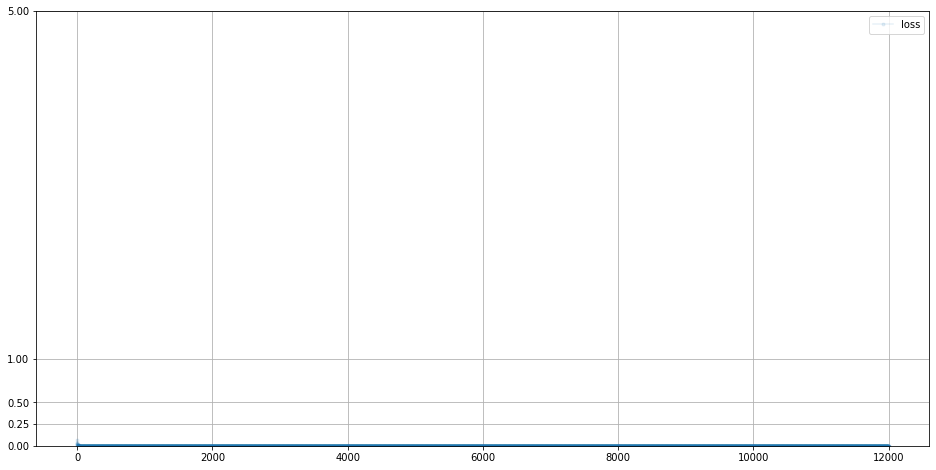

In [26]:
D.plot_progress()

In [27]:
for i in range(4):
  label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0,60000)]
  print(D.forward(image_data_tensor, label_tensor).item())

for i in range(4):
  print(D.forward(generate_random_image(784), generate_random_image(10)).item())

1.0
1.0
1.0
1.0
9.035661108214299e-12
9.610746226629274e-12
8.37306959877715e-12
1.063003331192025e-11


In [28]:

class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []
        
    
    
    def forward(self, seed_tensor, label_tensor):        
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        g_output = self.forward(inputs, label_tensor)
        
        d_output = D.forward(g_output, label_tensor)
        
        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


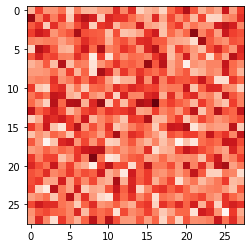

In [30]:
G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(10))
output = output.cpu() 

img = output.detach().numpy().reshape(28,28) #the .cpu() command could also be put between the .detach() and the .numpy() 

plt.imshow(img, interpolation='none', cmap='Reds')

In [31]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla K80


device(type='cuda')

In [32]:
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=110, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=200, out_features=784, bias=True)
    (4): Sigmoid()
  )
)

In [33]:
%%time

epochs = 20

for epoch in range(epochs):
  print("epoch = ", epoch +1)

  for label, image_data_tensor, label_tensor in mnist_dataset:
    D.train(image_data_tensor,label_tensor, torch.cuda.FloatTensor([1.0]))
    random_label = generate_random_one_hot(10)

    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.cuda.FloatTensor([0.0]))

    random_label = generate_random_one_hot(10)

    G.train(D, generate_random_seed(100), random_label, torch.cuda.FloatTensor([1.0]))



epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
epoch =  5
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000


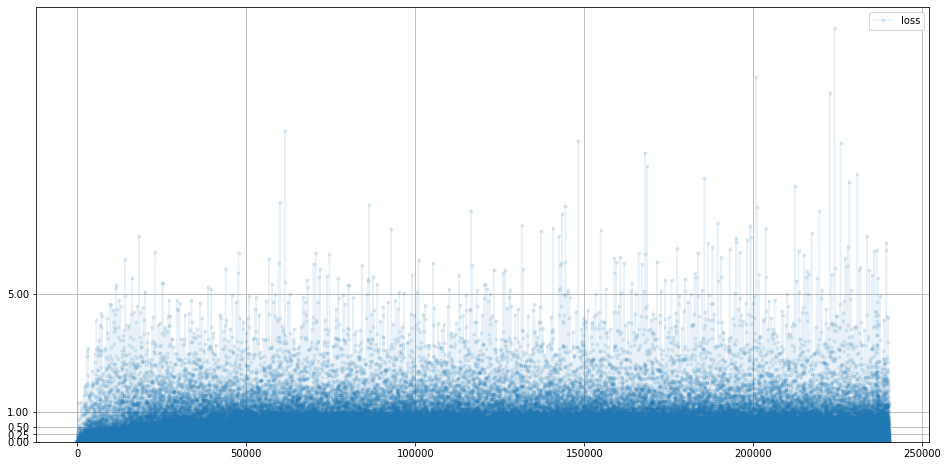

In [34]:
D.plot_progress()

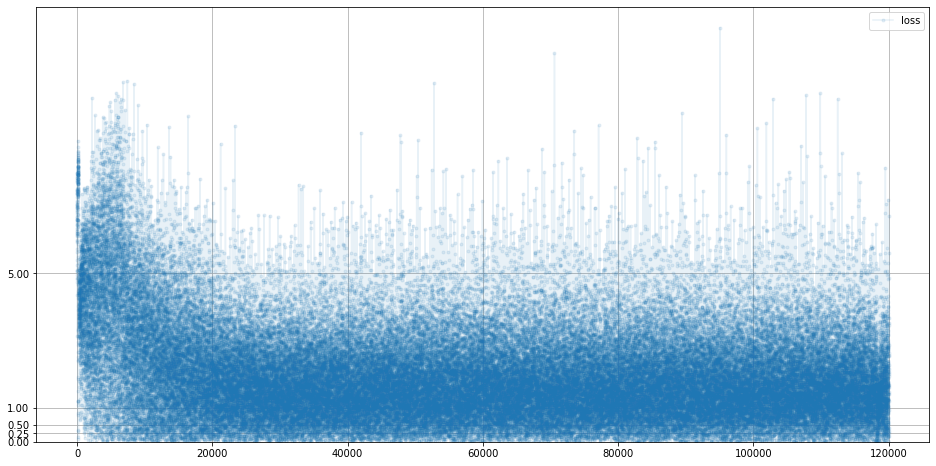

In [35]:
G.plot_progress()

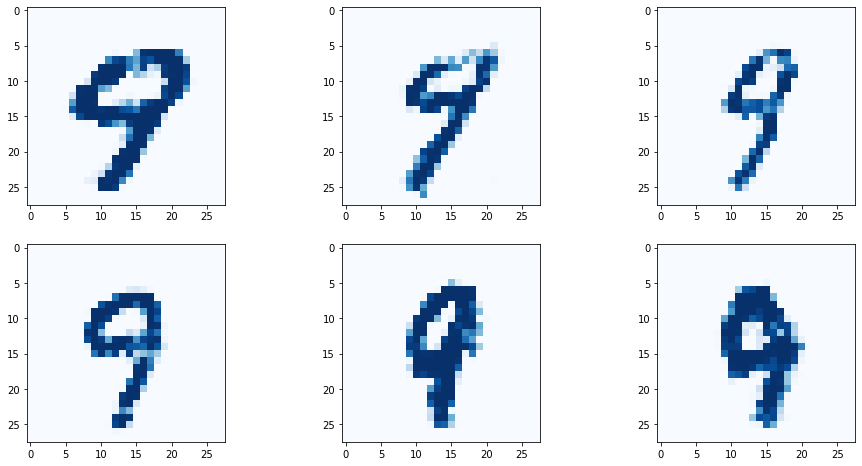

In [36]:
G.plot_images(9)

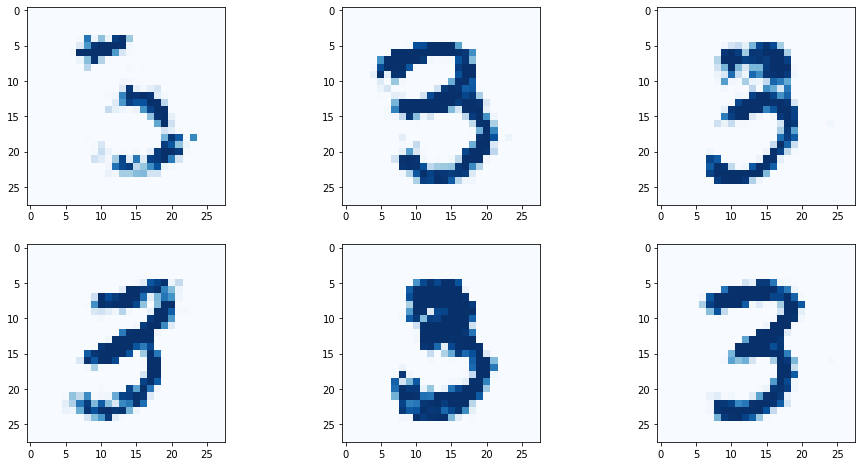

In [37]:
G.plot_images(3)

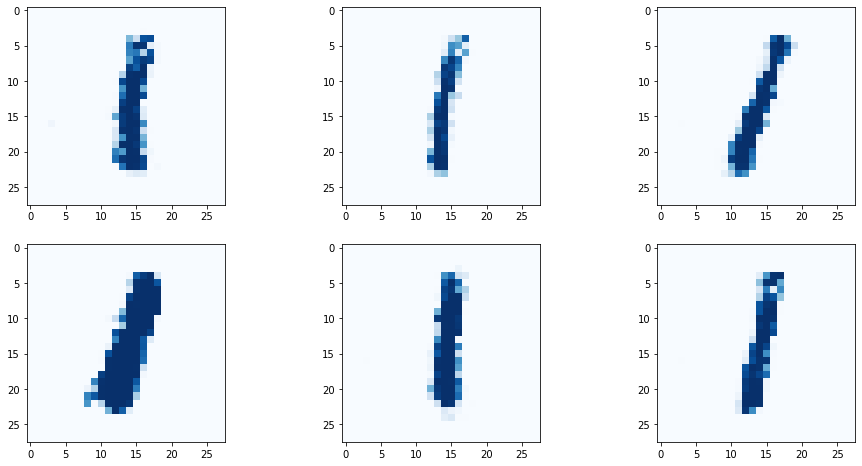

In [38]:
G.plot_images(1)

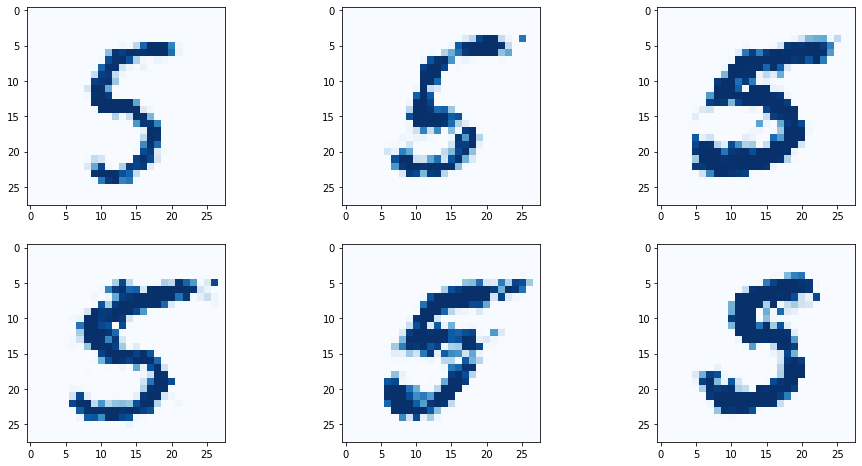

In [39]:
G.plot_images(5)